# TRANSFORMER FOR SEQUENCE TO SEQUENCE WITH PADDING

Ce notebook montre un transformer pour la génération de séquence à  partr des séquences enregitrées par l'Agent12

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# --- Configuration ---

VOCAB_SIZE = 13  # 10 tokens + <sos>=9, <eos>=11, <pad>=12
SOS_TOKEN = 9
EOS_TOKEN = 11
PAD_TOKEN = 12
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## On crée un dataloader qui se charge d'ajouter les SOS_TOKEN, EOS_TOKEN et PAD_TOKEN

In [2]:
# --- 1. Dataset & DataLoader ---

class Seq2SeqDataset(Dataset):
    def __init__(self, sequences):
        self.data = []
        for src, tgt in sequences:
            tgt_input = [SOS_TOKEN] + tgt
            tgt_output = tgt + [EOS_TOKEN]
            self.data.append((torch.tensor(src), torch.tensor(tgt_input), torch.tensor(tgt_output)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def collate_fn(batch):
    src_batch, tgt_in_batch, tgt_out_batch = zip(*batch)

    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=PAD_TOKEN)
    tgt_in_padded = pad_sequence(tgt_in_batch, batch_first=True, padding_value=PAD_TOKEN)
    tgt_out_padded = pad_sequence(tgt_out_batch, batch_first=True, padding_value=PAD_TOKEN)

    return src_padded, tgt_in_padded, tgt_out_padded

def get_dataloader(sequences, batch_size=32):
    dataset = Seq2SeqDataset(sequences)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


## On crée le modèle

In [3]:
# --- 2. Transformer Model ---

class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=PAD_TOKEN)
        self.pos_encoding = nn.Parameter(torch.randn(512, d_model))  # max sequence length

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_linear = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt_in, src_key_padding_mask, tgt_key_padding_mask, tgt_mask):
        src_emb = self.embedding(src) + self.pos_encoding[:src.size(1)]
        tgt_emb = self.embedding(tgt_in) + self.pos_encoding[:tgt_in.size(1)]

        src_emb = src_emb.permute(1, 0, 2)  # (seq, batch, embed)
        tgt_emb = tgt_emb.permute(1, 0, 2)

        memory = self.encoder(src_emb, src_key_padding_mask=src_key_padding_mask)
        out = self.decoder(
            tgt_emb,
            memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask
        )
        out = self.output_linear(out)
        return out.permute(1, 0, 2)  # (batch, seq, vocab)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
        return mask.to(DEVICE)


## La fonction d'entrainement

In [4]:
def train_model(model, dataloader, num_epochs=10):
    # model = SimpleTransformer(VOCAB_SIZE).to(DEVICE)
    model.train()
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for src, tgt_in, tgt_out in dataloader:
            src, tgt_in, tgt_out = src.to(DEVICE), tgt_in.to(DEVICE), tgt_out.to(DEVICE)

            src_pad_mask = (src == PAD_TOKEN)
            tgt_pad_mask = (tgt_in == PAD_TOKEN)
            tgt_mask = model.generate_square_subsequent_mask(tgt_in.size(1))

            output = model(src, tgt_in, src_pad_mask, tgt_pad_mask, tgt_mask)

            loss = criterion(output.reshape(-1, VOCAB_SIZE), tgt_out.reshape(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")
    # return model


## La fonction de génération

In [5]:
# --- 4. Generation Function ---

def generate_sequence(model, input_sequence, max_len=50):
    model.eval()
    src = torch.tensor([input_sequence], dtype=torch.long).to(DEVICE)
    src_pad_mask = (src == PAD_TOKEN)
    src_emb = model.embedding(src) + model.pos_encoding[:src.size(1)]
    memory = model.encoder(src_emb.permute(1, 0, 2), src_key_padding_mask=src_pad_mask)

    generated = [SOS_TOKEN]
    for _ in range(max_len):
        tgt = torch.tensor([generated], dtype=torch.long).to(DEVICE)
        tgt_pad_mask = (tgt == PAD_TOKEN)
        tgt_mask = model.generate_square_subsequent_mask(tgt.size(1))

        tgt_emb = model.embedding(tgt) + model.pos_encoding[:tgt.size(1)]
        out = model.decoder(
            tgt_emb.permute(1, 0, 2),
            memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_pad_mask,
            memory_key_padding_mask=src_pad_mask
        )
        logits = model.output_linear(out[-1])
        next_token = torch.argmax(logits, dim=-1).item()
        if next_token == EOS_TOKEN:
            break
        generated.append(next_token)
    return generated[1:]  # remove <sos>


# Testons avec les séquences générées par l'agent 12

In [48]:
# Séquences de longueur 2 à 20

train_data = [[[0], [1]], [[1], [1]], [[0, 1], [1]], [[0], [1, 1]], [[1], [3]], [[1, 1], [3]], [[1], [1, 3]], [[0, 1], [1, 3]], [[3], [1]], [[1, 3], [1]], [[1], [3, 1]], [[1, 1], [3, 1]], [[1], [4]], [[3, 1], [4]], [[3], [1, 4]], [[1, 3], [1, 4]], [[4], [1]], [[1, 4], [1]], [[1], [4, 1]], [[3, 1], [4, 1]], [[1], [7]], [[4, 1], [7]], [[4], [1, 7]], [[1, 4], [1, 7]], [[7], [1]], [[1, 7], [1]], [[1], [7, 1]], [[4, 1], [7, 1]], [[1], [8]], [[7, 1], [8]], [[7], [1, 8]], [[1, 7], [1, 8]], [[8], [0]], [[1, 8], [0]], [[1], [8, 0]], [[7, 1], [8, 0]], [[0], [2]], [[8, 0], [2]], [[8], [0, 2]], [[1, 8], [0, 2]], [[2], [0]], [[0, 2], [0]], [[0], [2, 0]], [[8, 0], [2, 0]], [[2, 0], [2, 0]], [[2], [0, 2, 0]], [[0, 2], [0, 2, 0]], [[2, 0], [3]], [[0, 2, 0], [3]], [[0], [2, 0, 3]], [[2, 0], [2, 0, 3]], [[3], [3]], [[2, 0, 3], [3]], [[2, 0], [3, 3]], [[0, 2, 0], [3, 3]], [[3], [4]], [[3, 3], [4]], [[3], [3, 4]], [[2, 0, 3], [3, 4]], [[4], [3]], [[3, 4], [3]], [[3], [4, 3]], [[3, 3], [4, 3]], [[3], [7]], [[4, 3], [7]], [[4], [3, 7]], [[3, 4], [3, 7]], [[7], [3]], [[3, 7], [3]], [[3], [7, 3]], [[4, 3], [7, 3]], [[3], [8]], [[7, 3], [8]], [[7], [3, 8]], [[3, 7], [3, 8]], [[3, 8], [0, 2]], [[3], [8, 0, 2]], [[7, 3], [8, 0, 2]], [[8, 0, 2], [0, 2, 0]], [[8], [0, 2, 0, 2, 0]], [[3, 8], [0, 2, 0, 2, 0]], [[0, 2, 0, 2, 0], [3]], [[0, 2], [0, 2, 0, 3]], [[8, 0, 2], [0, 2, 0, 3]], [[3], [10]], [[0, 2, 0, 3], [10]], [[0, 2, 0], [3, 10]], [[0, 2, 0, 2, 0], [3, 10]], [[10], [1]], [[3, 10], [1]], [[3], [10, 1]], [[0, 2, 0, 3], [10, 1]], [[1], [10]], [[10, 1], [10]], [[10], [1, 10]], [[3, 10], [1, 10]], [[10], [2]], [[1, 10], [2]], [[1], [10, 2]], [[10, 1], [10, 2]], [[10, 2], [0, 2, 0]], [[10], [2, 0, 2, 0]], [[1, 10], [2, 0, 2, 0]], [[0, 2, 0], [2, 0, 3]], [[2, 0, 2, 0], [2, 0, 3]], [[2], [0, 2, 0, 2, 0, 3]], [[10, 2], [0, 2, 0, 2, 0, 3]], [[2, 0, 3], [5]], [[0, 2, 0, 2, 0, 3], [5]], [[0, 2, 0], [2, 0, 3, 5]], [[2, 0, 2, 0], [2, 0, 3, 5]], [[5], [1]], [[2, 0, 3, 5], [1]], [[2, 0, 3], [5, 1]], [[0, 2, 0, 2, 0, 3], [5, 1]], [[5, 1], [3]], [[5], [1, 3]], [[2, 0, 3, 5], [1, 3]], [[1, 3], [3]], [[1], [3, 3]], [[5, 1], [3, 3]], [[3], [5]], [[3, 3], [5]], [[3], [3, 5]], [[1, 3], [3, 5]], [[5], [3]], [[3, 5], [3]], [[3], [5, 3]], [[3, 3], [5, 3]], [[3], [6]], [[5, 3], [6]], [[5], [3, 6]], [[3, 5], [3, 6]], [[6], [1]], [[3, 6], [1]], [[3], [6, 1]], [[5, 3], [6, 1]], [[1], [5]], [[6, 1], [5]], [[6], [1, 5]], [[3, 6], [1, 5]], [[5], [5]], [[1, 5], [5]], [[1], [5, 5]], [[6, 1], [5, 5]], [[5], [6]], [[5, 5], [6]], [[5], [5, 6]], [[1, 5], [5, 6]], [[6], [3]], [[5, 6], [3]], [[5], [6, 3]], [[5, 5], [6, 3]], [[6, 3], [3]], [[6], [3, 3]], [[5, 6], [3, 3]], [[6, 3], [3, 5]], [[5], [8]], [[3, 5], [8]], [[3], [5, 8]], [[3, 3], [5, 8]], [[8], [1]], [[5, 8], [1]], [[5], [8, 1]], [[3, 5], [8, 1]], [[8, 1], [7]], [[8], [1, 7]], [[5, 8], [1, 7]], [[7], [4]], [[1, 7], [4]], [[1], [7, 4]], [[8, 1], [7, 4]], [[4], [4]], [[7, 4], [4]], [[7], [4, 4]], [[1, 7], [4, 4]], [[4], [7]], [[4, 4], [7]], [[4], [4, 7]], [[7, 4], [4, 7]], [[7], [7]], [[4, 7], [7]], [[4], [7, 7]], [[4, 4], [7, 7]], [[7], [8]], [[7, 7], [8]], [[7], [7, 8]], [[4, 7], [7, 8]], [[7, 8], [0, 2, 0, 2, 0]], [[7], [8, 0, 2, 0, 2, 0]], [[7, 7], [8, 0, 2, 0, 2, 0]], [[8, 0, 2, 0, 2, 0], [3]], [[8], [0, 2, 0, 2, 0, 3]], [[7, 8], [0, 2, 0, 2, 0, 3]], [[0, 2, 0, 2, 0, 3], [7]], [[0, 2, 0, 2, 0], [3, 7]], [[8, 0, 2, 0, 2, 0], [3, 7]], [[0], [3]], [[0, 2], [0, 3]], [[8], [0, 2, 0, 3]], [[7], [8, 0, 2, 0, 3]], [[3, 7], [8, 0, 2, 0, 3]], [[3], [7, 8, 0, 2, 0, 3]], [[0, 2, 0, 2, 0, 3], [7, 8, 0, 2, 0, 3]], [[8], [0, 3]], [[7], [8, 0, 3]], [[8, 0, 2, 0, 3], [7, 8, 0, 3]], [[7, 8, 0, 2, 0, 3], [7, 8, 0, 3]], [[7], [8, 0, 2, 0, 3, 7, 8, 0, 3]], [[3, 7], [8, 0, 2, 0, 3, 7, 8, 0, 3]], [[7, 8, 0, 3], [6]], [[8, 0, 2, 0, 3, 7, 8, 0, 3], [6]], [[8, 0, 2, 0, 3], [7, 8, 0, 3, 6]], [[7, 8, 0, 2, 0, 3], [7, 8, 0, 3, 6]], [[6], [5]], [[7, 8, 0, 3, 6], [5]], [[7, 8, 0, 3], [6, 5]], [[8, 0, 2, 0, 3, 7, 8, 0, 3], [6, 5]], [[5], [10]], [[6, 5], [10]], [[6], [5, 10]], [[7, 8, 0, 3, 6], [5, 10]], [[2], [0, 3]], [[10], [2, 0, 3]], [[5, 10], [2, 0, 3]], [[5], [10, 2, 0, 3]], [[6, 5], [10, 2, 0, 3]], [[2, 0, 3], [7, 8, 0, 2, 0, 3]], [[10, 2, 0, 3], [7, 8, 0, 2, 0, 3]], [[10], [2, 0, 3, 7, 8, 0, 2, 0, 3]], [[5, 10], [2, 0, 3, 7, 8, 0, 2, 0, 3]], [[0, 2], [0, 2]], [[8], [0, 2, 0, 2]], [[7], [8, 0, 2, 0, 2]], [[7, 8, 0, 2, 0, 3], [7, 8, 0, 2, 0, 2]], [[2, 0, 3, 7, 8, 0, 2, 0, 3], [7, 8, 0, 2, 0, 2]], [[2, 0, 3], [7, 8, 0, 2, 0, 3, 7, 8, 0, 2, 0, 2]], [[10, 2, 0, 3], [7, 8, 0, 2, 0, 3, 7, 8, 0, 2, 0, 2]], [[7, 8, 0, 2, 0, 2], [0, 3]], [[7, 8, 0, 2, 0, 3, 7, 8, 0, 2, 0, 2], [0, 3]], [[7, 8, 0, 2, 0, 3], [7, 8, 0, 2, 0, 2, 0, 3]], [[2, 0, 3, 7, 8, 0, 2, 0, 3], [7, 8, 0, 2, 0, 2, 0, 3]], [[0, 3], [7, 8, 0, 2, 0, 2]], [[7, 8, 0, 2, 0, 2, 0, 3], [7, 8, 0, 2, 0, 2]], [[7, 8, 0, 2, 0, 2], [0, 3, 7, 8, 0, 2, 0, 2]], [[0, 3, 7, 8, 0, 2, 0, 2], [0, 3]], [[0, 3], [7, 8, 0, 2, 0, 2, 0, 3]], [[7, 8, 0, 2, 0, 2, 0, 3], [7, 8, 0, 2, 0, 2, 0, 3]]]

In [47]:
# Séquences de longuer 10 à 20

train_data = [[[0, 2, 0, 2, 0, 3], [7, 8, 0, 2, 0, 3]], [[7, 8, 0, 2, 0, 3], [7, 8, 0, 3]], [[7], [8, 0, 2, 0, 3, 7, 8, 0, 3]], [[3, 7], [8, 0, 2, 0, 3, 7, 8, 0, 3]], [[8, 0, 2, 0, 3, 7, 8, 0, 3], [6]], [[8, 0, 2, 0, 3], [7, 8, 0, 3, 6]], [[7, 8, 0, 2, 0, 3], [7, 8, 0, 3, 6]], [[8, 0, 2, 0, 3, 7, 8, 0, 3], [6, 5]], [[10, 2, 0, 3], [7, 8, 0, 2, 0, 3]], [[10], [2, 0, 3, 7, 8, 0, 2, 0, 3]], [[5, 10], [2, 0, 3, 7, 8, 0, 2, 0, 3]], [[7, 8, 0, 2, 0, 3], [7, 8, 0, 2, 0, 2]], [[2, 0, 3, 7, 8, 0, 2, 0, 3], [7, 8, 0, 2, 0, 2]], [[2, 0, 3], [7, 8, 0, 2, 0, 3, 7, 8, 0, 2, 0, 2]], [[10, 2, 0, 3], [7, 8, 0, 2, 0, 3, 7, 8, 0, 2, 0, 2]], [[7, 8, 0, 2, 0, 3, 7, 8, 0, 2, 0, 2], [0, 3]], [[7, 8, 0, 2, 0, 3], [7, 8, 0, 2, 0, 2, 0, 3]], [[2, 0, 3, 7, 8, 0, 2, 0, 3], [7, 8, 0, 2, 0, 2, 0, 3]], [[7, 8, 0, 2, 0, 2, 0, 3], [7, 8, 0, 2, 0, 2]], [[7, 8, 0, 2, 0, 2], [0, 3, 7, 8, 0, 2, 0, 2]], [[0, 3, 7, 8, 0, 2, 0, 2], [0, 3]], [[0, 3], [7, 8, 0, 2, 0, 2, 0, 3]], [[7, 8, 0, 2, 0, 2, 0, 3], [7, 8, 0, 2, 0, 2, 0, 3]]]

In [27]:
torch.manual_seed(0)

dataloader = get_dataloader(train_data, batch_size=32)
model = SimpleTransformer(VOCAB_SIZE, d_model=16).to(DEVICE)

train_model(model, dataloader, num_epochs=60)

Epoch 1, Loss: 2.8458
Epoch 2, Loss: 2.3066
Epoch 3, Loss: 2.0884
Epoch 4, Loss: 1.9890
Epoch 5, Loss: 1.9302
Epoch 6, Loss: 1.8731
Epoch 7, Loss: 1.8218
Epoch 8, Loss: 1.7536
Epoch 9, Loss: 1.6897
Epoch 10, Loss: 1.6521
Epoch 11, Loss: 1.5950
Epoch 12, Loss: 1.5303
Epoch 13, Loss: 1.4768
Epoch 14, Loss: 1.4247
Epoch 15, Loss: 1.4054
Epoch 16, Loss: 1.3581
Epoch 17, Loss: 1.3305
Epoch 18, Loss: 1.2815
Epoch 19, Loss: 1.2797
Epoch 20, Loss: 1.2503
Epoch 21, Loss: 1.2367
Epoch 22, Loss: 1.2310
Epoch 23, Loss: 1.1920
Epoch 24, Loss: 1.1913
Epoch 25, Loss: 1.1786
Epoch 26, Loss: 1.1569
Epoch 27, Loss: 1.1641
Epoch 28, Loss: 1.1325
Epoch 29, Loss: 1.1122
Epoch 30, Loss: 1.1126
Epoch 31, Loss: 1.0979
Epoch 32, Loss: 1.0821
Epoch 33, Loss: 1.0648
Epoch 34, Loss: 1.0499
Epoch 35, Loss: 1.0335
Epoch 36, Loss: 1.0390
Epoch 37, Loss: 1.0147
Epoch 38, Loss: 1.0119
Epoch 39, Loss: 0.9844
Epoch 40, Loss: 0.9874
Epoch 41, Loss: 0.9875
Epoch 42, Loss: 0.9528
Epoch 43, Loss: 0.9445
Epoch 44, Loss: 0.95

In [28]:
# Génération
tests = [[0], [1], [2], [3], [8, 0, 2, 0, 2, 0, 3]]

for seq in tests:
    generated = generate_sequence(model, seq)
    print(seq, "->", generated)


[0] -> [7, 8, 0, 2, 0, 2, 0, 3]
[1] -> [7, 8, 0, 2, 0, 2, 0, 3]
[2] -> [7, 8, 0, 2, 0, 2, 0, 3]
[3] -> [7, 8, 0, 2, 0, 2, 0, 3]
[8, 0, 2, 0, 2, 0, 3] -> [7, 8, 0, 2, 0, 2, 0, 3]


# On visualise l'embedding

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

# Liste de formes de marqueurs disponibles dans Plotly
marker_symbols = ['diamond', 'diamond', 'square', 'square', 'square', 'square','square', 'square', 'circle', 'cross', 'circle', 'cross']
# Couleurs (différentes pour chaque token)
marker_colors = ['#D6D6D6', '#F93943', '#FAE2DB', '#535865', '#FAE2DB', '#535865', '#FAE2DB', '#535865', '#D6D6D6', '#D6D6D6', '#D6D6D6', '#D6D6D6']

labels = ['forward', 'bump', 'front_empty', 'front_wall', 'left_empty', 'left_wall','right_empty', 'right_wall', 'turn_left', 'turn_left', 'turn_right', 'turn_righ']
tags = ['forward', 'bump', 'front', 'front', 'left', 'left','right', 'right', 'left', '', 'right', '']

def plotly_embedding(embedding_weights):
    # Extraire les vecteurs d'embedding
    # embedding_weights = agent._lstm.embedding.weight.data        
    # Récupérer les coordonnées
    x = embedding_weights[:, 0].detach().numpy()
    y = embedding_weights[:, 1].detach().numpy()
    z = embedding_weights[:, 2].detach().numpy()
    #labels = [f"Token {i}" for i in range(agent._lstm.len_vocab)]
    # Créer une figure Plotly
    fig = go.Figure()
    
    for i in range(12):
        # Exclude the turn wall interactions
        if i in [9, 11]:
            continue
        fig.add_trace(go.Scatter3d(
            x=[x[i]],
            y=[y[i]],
            z=[z[i]],
            mode='markers+text',
            name=labels[i],
            marker=dict(
                size=10,
                color=marker_colors[i],
                symbol=marker_symbols[i],
                line=dict(width=1, color='black')
            ),
            text= tags[i],
            textposition='top center'
        ))    
    fig.update_layout(
        # title='Visualisation 3D des embeddings',
        width=900,
        height=700,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        )
    )  
    # Affichage interactif
    fig.show(config={"toImageButtonOptions": {"format": "svg"}}) # Spécifie le format de sauvegarde associé au bouton "download" 

In [49]:
# Projection par la methode des Feature Agglomeration

group_axes = {
    "direction_forward": [0, 1, 2, 3],      # Tokens : forward, front_empty, front_wall
    "direction_left": [4, 5, 8],      # left_empty, left_wall, turn_left, turn_left (duplicated)
    "direction_right": [6, 7, 10],   # right_empty, right_wall, turn_right, turn_right
    "move": [0, 8, 10],             # forward, turn_left, turn_right
    "feel_wall": [3, 5, 7],         # bump, front_wall, left_wall, right_wall
    "feel_empty": [2, 4, 6],
}

def project_token_embeddings_to_3D(model):
    """
    Renvoie un tenseur (vocab_size, 3) correspondant aux embeddings de tokens projetés dans ℝ³.
    """
    projections = []
    for group in group_axes.values():
        group_embedding = model.embedding.weight[group].mean(dim=0)
        projections.append(group_embedding)
    projection_matrix = torch.stack(projections)  # shape (n_axes, d_model)

    projected = torch.matmul(model.embedding.weight, projection_matrix.T) 

    return projected


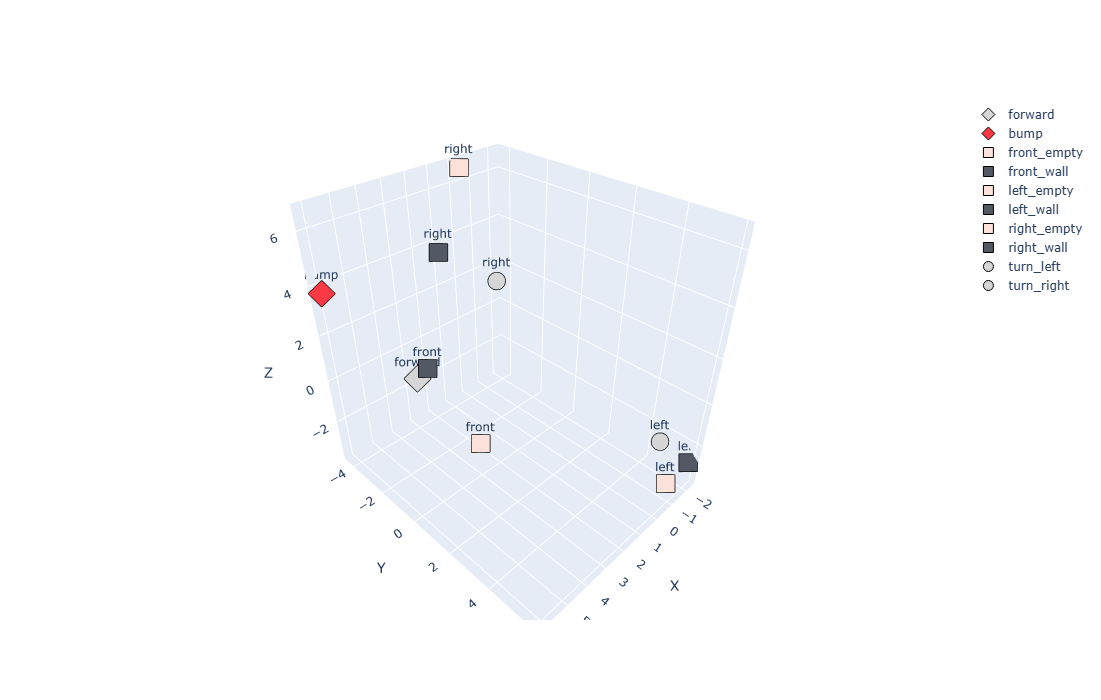

In [51]:
projected = project_token_embeddings_to_3D(model)
plotly_embedding(projected)

Sous certains angles de projection, on voit des regroupements intéressants des tokens par coté (Figure 1) ou par type de sensation ("emtpy" / "wall") (Figure 2)

![Figure 1](img/7-embedding_lateralisation.svg)

_Figure 1: Projection qui met en évidence les regroupements par coté ("left", "front", "right")_

![Figure 1](img/7-embedding_feel.svg)

_Figure 2: Projection qui met en évidence les regroupements par type de sensation ("empty" ou "wall")_